In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

import sys
sys.path.append("../")

from utils.dataset import FreiHAND, HanCo
from utils.model import ShallowUNet, SimpleCNN, LeveledUNet
from utils.trainer import Trainer
from utils.prep_utils import (
    blur_heatmaps,
    IoULoss,
    COLORMAP,
    N_KEYPOINTS,
    N_IMG_CHANNELS,
    get_norm_params,
    show_data,
    
)
from torchvision import datasets, transforms


### Train Parameters

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)
dataset_type = HanCo#FreiHAND
data_dir = "/scratch/palle.a/AirKeyboard/data/hanco_all/HanCo"#"/scratch/palle.a/AirKeyboard/data/freihand_all/FreiHAND_pub_v2"

config = {
    "data_dir": data_dir,
    "epochs": 1000,
    "batch_size": 4,
    "batches_per_epoch": 10,
    "batches_per_epoch_val":  5,
    "learning_rate": 0.1,
    "device":device ,
    "n_samples" : 1000,
    "save_per_n_epochs" : 10
}
data_prepped = False

cuda


## Data

In [4]:

if not data_prepped:

   # train_dataset = FreiHAND(config=config, set_type="train")
#     train_dataloader = DataLoader(
#         train_dataset, config["batch_size"], shuffle=True, drop_last=True, num_workers=2
#     )
    
    
#     get_norm_params(train_dataloader)
     # 80/10/10 Train/val/test split
    train_dataset = dataset_type(config=config, set_type="train")
    train_dataloader = DataLoader(
        train_dataset, config["batch_size"], shuffle=True, drop_last=True, num_workers=2
    )

    val_dataset = dataset_type(config=config, set_type="val")
    val_dataloader = DataLoader(
        val_dataset, config["batch_size"], shuffle=True, drop_last=True, num_workers=2
    )
    
    
    #data_prepped = True

100%|██████████| 800/800 [00:24<00:00, 32.68it/s]
800it [00:00, 1494.48it/s]
100%|██████████| 100/100 [00:03<00:00, 33.29it/s]
100it [00:00, 182.37it/s]


In [5]:
print(len(train_dataloader),len(val_dataloader) )

get_norm_params(train_dataloader)

200 25


200it [00:13, 14.90it/s]


{'mean': tensor([0.4424, 0.4488, 0.3851]),
 'std': tensor([0.2167, 0.2015, 0.2329])}

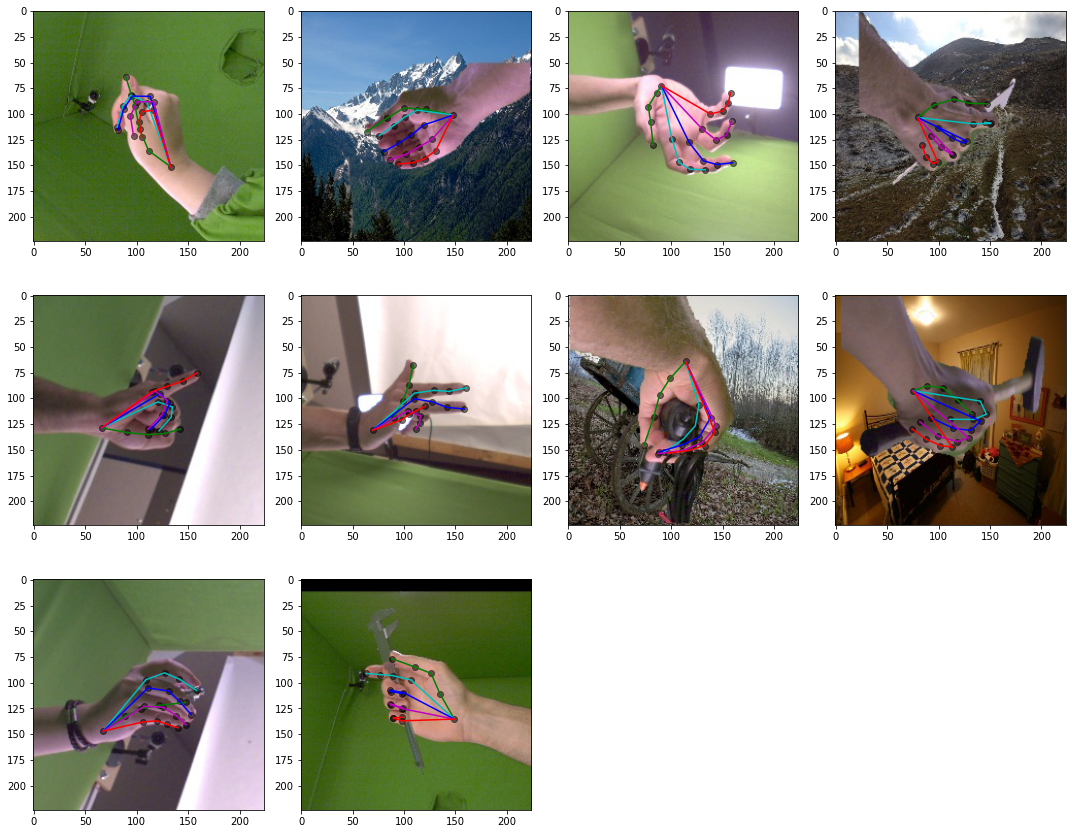

In [6]:
# visualize random batch of data train samples + labels
show_data(train_dataset, n_samples=10)

## Model

In [7]:


model = LeveledUNet(N_IMG_CHANNELS, N_KEYPOINTS, levels = 6)#SimpleCNN(N_IMG_CHANNELS, N_KEYPOINTS)
model2 = ShallowUNet(N_IMG_CHANNELS, N_KEYPOINTS)

example = torch.rand(48,3,128,128)

model2.forward(example)
model.forward(example) # sanity check


# traced_model = torch.jit.trace(model,example)
# traced_model.save(save_loc)
model = model.to(config["device"])

criterion = IoULoss()
optimizer = optim.SGD(model.parameters(), lr=config["learning_rate"])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, factor=0.5, patience=20, verbose=True, threshold=0.00001
)

## Training

In [9]:
trainer = Trainer(model, criterion, optimizer, config, scheduler)
model = trainer.train(train_dataloader, val_dataloader, "/scratch/palle.a/AirKeyboard/python_sample/weights/test_model")

Epoch: 1/1000, Train Loss=0.9932405515, Val Loss=0.9931520422
0 Epochs elapse, checkpointing training state
Epoch: 2/1000, Train Loss=0.9932452115, Val Loss=0.9931581616
Epoch: 3/1000, Train Loss=0.9932097359, Val Loss=0.9932001432
Epoch: 4/1000, Train Loss=0.9932210662, Val Loss=0.9932095508
Epoch: 5/1000, Train Loss=0.9931939624, Val Loss=0.9931918482
Epoch: 6/1000, Train Loss=0.9932065281, Val Loss=0.9931763212
Epoch: 7/1000, Train Loss=0.9931789853, Val Loss=0.993170927
Epoch: 8/1000, Train Loss=0.9931897088, Val Loss=0.9931444923
Epoch: 9/1000, Train Loss=0.9931507111, Val Loss=0.9931590954
Epoch: 10/1000, Train Loss=0.9931430979, Val Loss=0.9930961927
Epoch: 11/1000, Train Loss=0.993141028, Val Loss=0.9931772749
10 Epochs elapse, checkpointing training state
Epoch: 12/1000, Train Loss=0.9931450107, Val Loss=0.9931295315
Epoch: 13/1000, Train Loss=0.9931002043, Val Loss=0.9931406975
Epoch: 14/1000, Train Loss=0.9931160266, Val Loss=0.9931512177
Epoch: 15/1000, Train Loss=0.9930981

In [ ]:
plt.plot(trainer.loss["train"], label="train")
plt.plot(trainer.loss["val"], label="val")
plt.legend()
plt.show()





In [ ]:
# SAVING
save_loc = "/scratch/palle.a/AirKeyboard/python_sample/weights/test_model"
torch.save(model.state_dict(), save_loc+"_final_save")